# Demonstration of MuPT molecular representation for simple tripeptides

In [1]:
import numpy as np
import networkx as nx

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.AllChem import EmbedMolecule, Compute2DCoords

IPythonConsole.highlightSubstructs = False
scale : float = 300
aspect : float = 3/2
IPythonConsole.molSize = (int(aspect*scale), int(scale))


PEPTIDE_BOND_QUERY = Chem.MolFromSmarts('[#7]-[$([#6]=O)]')

def peptide_mol_from_FASTA(sequence : str) -> tuple[Chem.Mol, dict[str, Chem.Mol], int]:
    peptide = Chem.MolFromFASTA(sequence, sanitize=True)
    peptide = Chem.AddHs(peptide)
    # conf_id = EmbedMolecule(peptide)
    conf_id = Compute2DCoords(peptide)

    # MAP ATOMS BY RESIDUE
    for atom in peptide.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())

    residue_fragments = Chem.GetMolFrags(
        Chem.FragmentOnBonds(
            peptide,
            bondIndices=[
                peptide.GetBondBetweenAtoms(*match).GetIdx()
                    for match in peptide.GetSubstructMatches(PEPTIDE_BOND_QUERY)
            ]
        ),
        asMols=True,
        sanitizeFrags=False,
    )
    assert len(residue_fragments) == len(sequence)
    
    residue_mols = {}
    for AA_label, (fragment_idx, fragment) in zip(sequence, enumerate(residue_fragments, start=1)):
        for atom in fragment.GetAtoms():
            target_atom = peptide.GetAtomWithIdx(atom.GetAtomMapNum())
            target_atom.SetAtomMapNum(fragment_idx)
            target_atom.SetProp('amino_acid', AA_label)
            
            atom.SetProp('amino_acid', AA_label)
            atom.SetAtomMapNum(0)
        residue_mols[AA_label] = fragment
            
    return peptide, residue_mols, conf_id

def topology_to_positions(top : nx.Graph, level_idx : int=0, layout_fn=nx.kamada_kawai_layout):
    node_positions = np.zeros((len(top), 3), dtype=float)
    node_positions[:, -1] = level_idx
    
    node_map = {node : i for i, node in enumerate(top.nodes)}
    pos = layout_fn(top)
    for node, position in pos.items():
        node_idx = node_map[node]
        node_positions[node_idx, :-1] = position
        
    edge_lines = [
        node_positions[ [node_map[node1], node_map[node2]] ]
            for (node1, node2) in top.edges
    ]
    return node_positions, edge_lines

def uniform_spacing_about_origin(n : int, scale : float=1.0) -> np.ndarray:
    mean_pos = (n - 1)*scale/2
    
    return np.arange(n, dtype=float)*scale - mean_pos

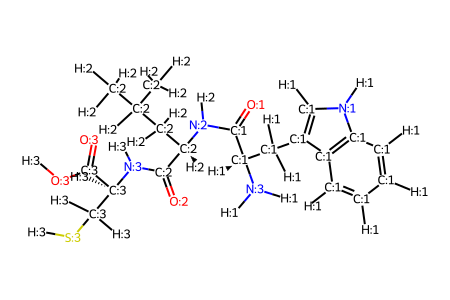

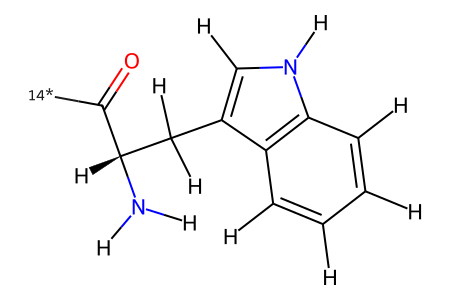

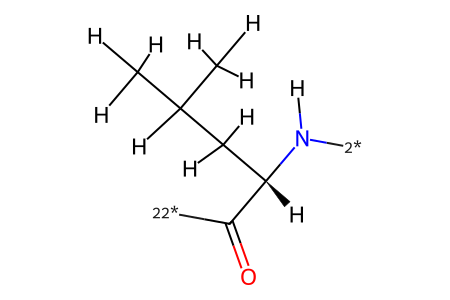

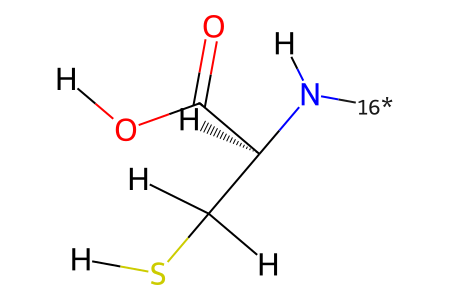

In [2]:
from mupt.interfaces.rdkit import primitive_from_rdkit


AA_PDB_CODES : dict[str, str] = {
    'G' : 'GLY',
    'A' : 'ALA',
    'V' : 'VAL',
    'L' : 'LEU',
    'I' : 'ILE',
    'T' : 'THR',
    'S' : 'SER',
    'M' : 'MET',
    'C' : 'CYS',
    'P' : 'PRO',
    'F' : 'PHE',
    'Y' : 'TYR',
    'W' : 'TRP',
    'H' : 'HIS',
    'K' : 'LYS',
    'R' : 'ARG',
    'D' : 'ASP',
    'E' : 'GLU',
    'N' : 'ASN',
    'Q' : 'GLN',
}


# seq : str = 'AFCH'
seq : str = 'WLC'
peptide, residues, conf_id = peptide_mol_from_FASTA(seq)

display(peptide)
for AA, residue in residues.items():
    display(residue)

In [3]:
from mupt.geometry.shapes import PointCloud
from mupt.mupr.primitives import Primitive

universe_prim = Primitive(label='Universe')

positions = peptide.GetConformer(conf_id).GetPositions()
molecule_prim = Primitive(shape=PointCloud(positions), label='Molecule')
universe_prim.attach_child(molecule_prim)

prev_prim_handle = None
for aa_code, residue in residues.items():
    residue_prim = primitive_from_rdkit(residue, conformer_id=conf_id, label=aa_code)
    nb_handles = set()
    if prev_prim_handle is not None:
        nb_handles.add(prev_prim_handle)
    
    handle = molecule_prim.attach_child(residue_prim, label=AA_PDB_CODES[aa_code])
    prev_prim_handle = handle


/home/timber/miniconda3/envs/mupt-dev/lib/python3.13/site-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributeschanged in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)


KeyError: '14 is not an isotope of n'

## Visualizing Primitive Hierarchy

In [ ]:
import matplotlib.pyplot as plt
%matplotlib ipympl
from matplotlib.colors import rgb2hex
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from anytree.iterators import LevelOrderGroupIter


eps = 0.05
z_eps = np.array([0.0, 0.0, eps])

cmap = plt.get_cmap('Accent')

scale : float = 10
n_rows, n_cols = 1, 2
aspect = n_cols / n_rows
figsize = (aspect*scale, scale)

fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': '3d'})
ax.autoscale('off')
# ax.grid(False)
ax.grid(True)
# ax.axis('off')

ax.set_xlim(-12, 12)
ax.set_ylim(-4, 6)
ax.set_zlim(-0.5, 2.5)

ax.elev = 30
ax.azim = -60
ax.roll = 0

# ax.get_proj = lambda : np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.7, 1]))


plot_arrows : bool = True
# plot_arrows : bool = False
arrow_ratio : float = 0.1
arrow_color : str = 'grey'

# plot universe
universe_pos = np.array([0, 0, 2], dtype=float)
ax.scatter(*universe_pos, marker='o', edgecolor='k', color='b')
ax.text(*(universe_pos + z_eps), universe_prim.label, fontsize=12)

# plot mol
mol_pos = np.array([0, 0, 1.5], dtype=float)
ax.scatter(*mol_pos, marker='o', edgecolor='k', color='c')
ax.text(*(mol_pos + z_eps), molecule_prim.label, fontsize=12)
if plot_arrows:
    ax.quiver(*universe_pos, *mol_pos - universe_pos, color=arrow_color, arrow_length_ratio=0.2)

# plot residues
res_pos_x = uniform_spacing_about_origin(len(seq), scale=3)
node_pos_residue, edge_pos_residue = topology_to_positions(
    molecule_prim.topology,
    level_idx=1.0,
    layout_fn=lambda top : {(AA_PDB_CODES[aa_code], 0) : (-x_pos, 0) for aa_code, x_pos in zip(seq, res_pos_x)},
)
# add edges and arrows for residue
for edgepair in edge_pos_residue:
    ax.plot(*edgepair.T, marker='.', color='k')  # plot edges as lines
    
if plot_arrows:
    ax.quiver(*np.tile(mol_pos, (len(node_pos_residue), 1)).T, *(node_pos_residue - mol_pos).T, color=arrow_color, arrow_length_ratio=0.1)

## plot over each residue's parts
for i, (node_handle_res, node_pos_res) in enumerate(zip(molecule_prim.topology.nodes, node_pos_residue)):
    res_color = cmap(i / (len(molecule_prim.topology.nodes)))
    res_prim = molecule_prim.children_by_handle[node_handle_res]
    ax.scatter(*node_pos_res, marker='o', edgecolor='k', color=res_color)
    ax.text(*(node_pos_res + z_eps), node_handle_res[0], fontsize=12)

    # plot atoms
    node_pos_atoms, edge_pos_atoms = topology_to_positions(
        res_prim.topology,
        level_idx=0, 
        # level_idx=-1, 
        layout_fn=lambda top : {node : pos[:-1] for node, pos in zip(top.nodes, res_prim.shape.positions)},
    )
    
    for node_handle_atom, node_pos_atom in zip(res_prim.topology.nodes, node_pos_atoms):
        ax.scatter(*node_pos_atom, marker='o', edgecolor='k', color=res_color)
        ax.text(*(node_pos_atom + z_eps), node_handle_atom[1], fontsize=12)

    for edgepair in edge_pos_atoms:
        ax.plot(*edgepair.T, marker='.', color='k')  # plot edges as lines
        
    if plot_arrows:
        ax.quiver(
            *np.tile(node_pos_res, (len(node_pos_atoms), 1)).T,
            *(node_pos_atoms - node_pos_res).T,
            color=arrow_color,
            arrow_length_ratio=0.02,
        )

ax.get_proj = lambda : np.dot(Axes3D.get_proj(ax), np.diag([1.2, 0.6, 1.2, 0.8]))
plt.show()
